## Objective

In this notebook, we do basic textual analysis on the reviews available in all three subdatasets. They are available in the following files:


        |
        ├── BeerAdvocate.tar/   
        │   └── ratings.txt.gz   
        ├── RateBeer.tar/
        │   └── ratings.txt.gz
        └── matched_beer_data.tar/
            └── ratings.txt.gz
            
Our main objectives are:
* Identify the language distribution of text reviews in both sites (and in the intersection of them)
* Calculate summary statistics regarding review word count.
* Have a first notion of the most common words (that aren't stop words).
       

### Language identification

This task is performed by using Facebook's ```fasttext``` library, which allows language identification with a pre-trained model. The model is based on word embeddings and was trained on  Wikipedia, Tatoeba and SETimes content. More information can be found [here](https://fasttext.cc/docs/en/language-identification.html).

We implement a function ```NLP_utils.identify_lang```, which accepts a ```DataFrame``` pandas object representing a dataset with a column of reviews where language identification is needed. It uses fasttext to return a ```Series```object corresponding to the language predictions of the model. 

### Word count 

A histogram and summary statistics of word count are computed with a simple ```.apply(lambda x: len(x.split()))``` call on the text reviews.

In [1]:
import pandas as pd
from functions import NLP_utils
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaoprado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
COLUMNS_NAMES = ["count","beer_name","beer_id","brewery_name","brewery_id","style","abv","date","username","user_id","appearance","aroma","palate","taste","overall","rating","text"]


In [3]:
#Processing BeerAdvocate dataset
first = pd.read_csv(f"../data/BeerAdvocate_ratings_part_0.csv",low_memory=False)
first.columns = COLUMNS_NAMES 
#TODO: standardize NaNs between datasets
first = first[first['text'] != ' nan']

print("Started identifying languages and counting words...")
langs = NLP_utils.identify_lang(first)
first["word_count"] = first.text.apply(lambda x: len(x.split()))
counts = first.word_count
#There is a total of 17 csvs for BeerAdvocate textual ratings.
for index in range(1,17):
    temp = pd.read_csv(f"../data/BeerAdvocate_ratings_part_{index}.csv",low_memory=False)
    temp.columns = COLUMNS_NAMES 
    temp = temp[temp['text'] != ' nan']
    temp["word_count"] = first.text.apply(lambda x: len(x.split()))
    count = temp.word_count
    temp = NLP_utils.identify_lang(temp)
    langs = pd.concat([langs, temp])
    counts = pd.concat([counts, count])
print("Done!")

Started identifying langs and counting words...
Done!


Language repartition for BeerAdvocate reviews:


English               99.883198
French                 0.031226
Italian                0.022683
Spanish; Castilian     0.013440
German                 0.007880
                        ...    
Lithuanian             0.000037
Interlingua            0.000037
Hebrew (modern)        0.000037
Malayalam              0.000037
Swahili                0.000037
Name: text, Length: 71, dtype: float64

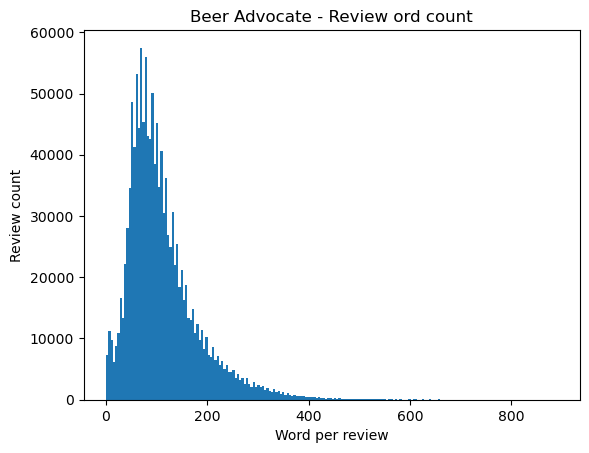

In [4]:
#Text review results for Beer Advocate dataset
plt.title('Beer Advocate - Review ord count')
plt.xlabel('Word per review')
plt.ylabel('Review count')
plt.hist(counts,bins=200, log=True)
print("Language repartition for BeerAdvocate reviews:")
langs.value_counts(normalize=True) * 100


In [5]:
#Processing RateBeer dataset
first = pd.read_csv(f"../data/RateBeer_ratings_part_0.csv",low_memory=False)
first.columns = COLUMNS_NAMES 
#TODO: standardize NaNs between datasets
first = first[first['text'] != 'NaN']

print("Started identifying languages and counting words...")
langs = NLP_utils.identify_lang(first)
first["word_count"] = first.text.apply(lambda x: len(str(x).split()))
counts = first.word_count
first["Language"] = langs
#There is a total of 15 csvs for RateBeer textual ratings.
for index in range(1,15):
    temp = pd.read_csv(f"../data/RateBeer_ratings_part_{index}.csv",dtype=object,low_memory=False)
    temp.columns = COLUMNS_NAMES 
    temp = temp[temp['text'] != 'NaN']
    temp["word_count"] = first.text.apply(lambda x: len(str(x).split()))
    count = temp.word_count
    temp = NLP_utils.identify_lang(temp)
    langs = pd.concat([langs, temp])
    counts = pd.concat([counts, count])
print("Done!")

Started identifying langs and counting words...
Done!


Language repartition for RateBeer reviews:


English          93.016065
Polish            1.483346
French            1.393611
German            1.035302
Dutch             0.513923
                   ...    
Interlingua       0.000014
Swahili           0.000014
Arabic            0.000014
Asturian          0.000014
Tosk Albanian     0.000014
Name: text, Length: 72, dtype: float64

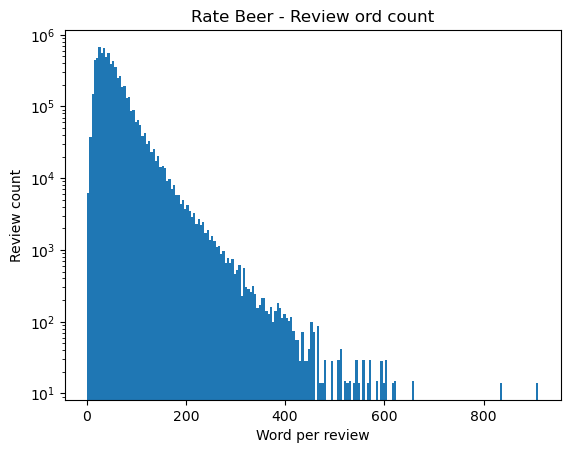

In [6]:
plt.title('Rate Beer - Review ord count')
plt.xlabel('Word per review')
plt.ylabel('Review count')
plt.hist(counts,bins=200, log=True)
print("Language repartition for RateBeer reviews:")
langs.value_counts(normalize=True) * 100

### Bonus :  wordcloud 

A wordcloud is created with the ```wordcloud``` package. Since datasets are dominated by english, french and polish reviews, we use ```sklearn.feature_extraction.text```to extract term frequencies and ```spacy```stopword lists for English, French and Polish, in order to filter common words that do not provide meaningful semantic content to reviews.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

final_stopwords_list = list(fr_stop) + list(en_stop) + ['ll', 'neuf', 'qu', 'quelqu', 've']

words_dict = {}

for index in range(0,15):
    temp = pd.read_csv(f"../data/RateBeer_ratings_part_{index}.csv",low_memory=False)
    temp.columns = COLUMNS_NAMES 
    vec = CountVectorizer(stop_words=final_stopwords_list).fit(first["text"].values.astype('U'))
    bag_of_words = vec.transform(first["text"].values.astype('U'))
    print(f"Finishing csv {index}")

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    for key, value in words_freq:
        if key not in words_dict:
            words_dict[key] = value
        else :
            words_dict[key] += value

Finishing csv 0
Finishing csv 1
Finishing csv 2
Finishing csv 3
Finishing csv 4
Finishing csv 5
Finishing csv 6
Finishing csv 7
Finishing csv 8
Finishing csv 9
Finishing csv 10


In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500,background_color="white").generate_from_frequencies(words_dict)
#Wordcloud for RateBeer
plt.figure(figsize=(15,8))
plt.axis("off")

plt.imshow(wordcloud)
